# Digit Recognizer
Ilan Valencius

# QUESTIONS
- Is number of layers a hyperparameter?
- Should I evaluate the best of every model on the test set?

## Load Data


In [3]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score
import numpy as np
import keras
import matplotlib.pyplot as plt
from math import log, exp
import itertools
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential, layers
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical

In [4]:
# Load CSV data
x_data = np.genfromtxt('handwritten_digits_images.csv', delimiter=',')
y_data = np.genfromtxt('handwritten_digits_labels.csv', delimiter=',')

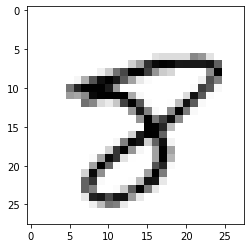

In [5]:
# Reshape images into 28 x 28 images
# x_data = x_data.reshape(x_data.shape[0], 28, 28)

# Plot image for quick sanity check
plt.imshow(x_data.reshape(x_data.shape[0], 28, 28)[60000], cmap='Greys')

## Create train, validation, test sets

In [6]:
seed = 120

x_train_val, x_test, y_train_val, y_test = train_test_split(x_data,
                                                            y_data,
                                                            test_size=0.2,
                                                            random_state=seed,
                                                            shuffle=True)

x_train, x_val, y_train, y_val = train_test_split(x_train_val,
                                                  y_train_val,
                                                  test_size=0.3,
                                                  random_state=seed, 
                                                  shuffle=True)

# Variables for model parameters
y_classes = len(np.unique(y_data))

In [31]:
# To compare models
model_type_accs = []
model_type_best = []

## Model 1 - MLP

In [17]:
def construct_MLP(input_shape, num_layers=10, activation='relu'):
    # Create model
    MLP = Sequential()
    MLP.add(layers.InputLayer(input_shape=input_shape))
    # Intermediate Layers
    for _ in range(num_layers):
        MLP.add(layers.Dense(32, activation=activation))
    # Output layer (fully-connected):
    MLP.add(layers.Dense(y_classes, activation='softmax'))
    # Compile Model
    MLP.compile(optimizer='adam',
                loss=categorical_crossentropy,
                metrics=['accuracy'])
    return MLP
            

Test MLP Model

*Note* - With all parameters at 10 epochs can take around 350 sec (NOT AN ERROR)

In [33]:
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)

# Set up hyperparameters to test
num_layers = [1, 2, 5, 10]
activation = ['relu', 'sigmoid', 'softmax', 'tanh']
MLP_params = list(itertools.product(num_layers, activation))

batch_sz = 64
max_epochs = 10
MLP_val_accs = []
MLP_models = []
# If you want Val_loss and Val_accuracy plots 
MLP_plotting = False
# Iterate through and test every model
for layer_num, act in MLP_params:
    MLP = construct_MLP(input_shape=784 ,num_layers=layer_num, activation=act)
    # MLP_test.summary()
    # Early callback stopping to avoid overfitting
    callback = EarlyStopping(monitor='val_loss',
                             patience=3,
                             restore_best_weights=True)
    
    training_history = MLP.fit(x=x_train,y=y_train_one_hot,
                                batch_size=batch_sz,
                                epochs=max_epochs,
                                validation_data=(x_val,y_val_one_hot),
                                use_multiprocessing=True,
                                verbose=0,
                                callbacks=[callback])
    MLP_models.append(MLP)
    
    val_acc = training_history.history['val_accuracy']
    MLP_val_accs.append(max(val_acc))
    if MLP_plotting:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('MLP Model - %d layers | %s activation'%(layer_num, act))
        
        loss = training_history.history['loss']
        val_loss = training_history.history['val_loss']
        acc = training_history.history['accuracy']
        
        epochs = range(1, len(loss) + 1)
        ax1.plot(epochs, loss, 'y', label='Training loss')
        ax1.plot(epochs, val_loss, 'r', label='Validation loss')
        ax1.title.set_text('Training and validation loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend(loc='best')
        
        ax2.plot(epochs, acc, 'y', label='Training Accuracy')
        ax2.plot(epochs, val_acc, 'r', label='Validation Accuracy')
        ax2.title.set_text('Training and validation Accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.legend(loc='best')
 

Determine best MLP model (using validation set)

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_263 (Dense)            (None, 32)                25120     
_________________________________________________________________
dense_264 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_265 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_266 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_267 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_268 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_269 (Dense)            (None, 32)              

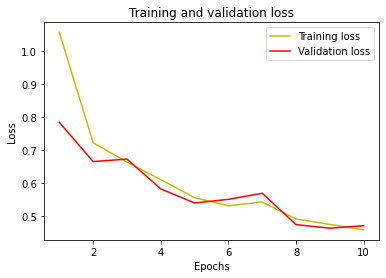

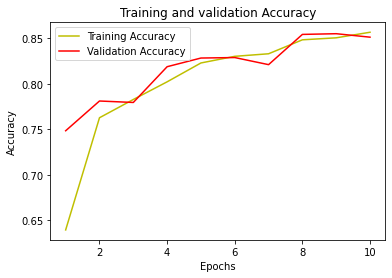

In [40]:
# Evaluate best model via validation accuracy
best_MLP_idx = MLP_val_accs.index(max(MLP_val_accs))
best_MLP = MLP_models[best_MLP_idx]
model_type_best.append(best_MLP)
best_MLP.summary()

activation = best_MLP.layers[1].get_config()['activation']
num_layers = len(best_MLP.layers)

print('\n\tActivation: %s\n\tNumber of Layers: %d'%(activation, num_layers))

# Evaluate on validation accuracy again and plot 
MLP_eval = best_MLP.evaluate(x=x_val, y=y_val_one_hot, use_multiprocessing=True, verbose=0)
MLP_loss = MLP_eval[0]
MLP_acc = MLP_eval[1]

model_type_accs.append(MLP_acc)

print('\nTest Set evaluation:')
print('\tLoss: %f | Accuracy: %f'%(MLP_loss, MLP_acc))
# Plot training history (train/validation loss and accuracy values throughout training):
loss = training_history.history['loss']
val_loss = training_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()